In [5]:
!pip install -e .

Obtaining file:///workspace/low-probability-estimation
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to prov

In [3]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 165.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 171.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 120.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [11]:
import torch as th
import sys
import os
import certifi
import matplotlib.pyplot as plt
from lpe.methods import QLD, GLD, ITGIS, MHIS, DA_MHIS, MT_MHIS, MT_MHIS_2
from lpe.method_utils import *
from lpe.utils import Transformer
from lpe.utils import datasets as lpe_datasets

In [12]:
model_name = "gelu-1l"
device = th.device("cuda" if th.cuda.is_available() else "cuda")
model = Transformer.from_pretrained(model_name).to(device)
device

device(type='cuda')

In [8]:
os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()
os.environ["BLOBFILE_FORCE_GOOGLE_ANONYMOUS_AUTH"] = "1"

In [13]:
dist_name = "camel"
gt_freqs = load_ground_truth(model_name, [dist_name], device=device)[dist_name] # get the output frequency of each token in the given dist #? might not even need [dist_name] argument inside in the function call
gt_probs = gt_freqs / gt_freqs.sum() # convert them to probabilities
targets = pick_random_tokens(gt_freqs, 16, 1e-9, 1e-5) # given those probabilites, pick random target tokens in the given probability range

In [10]:
## Uncomment this line to cache the dataset used to generate the distribution (recommended). It
##   will save the dataset in your default HuggingFace cache directory and speed up the next cell.
lpe_datasets.USE_CACHE = True

# Generate 2^16 samples of the pre-unembed activations (used for QLD and GLD)
#acts = gen_activ_samples(model, dist_name, n_samples=2**16, show_progress=True)

In [15]:
# Generate estimates
methods = ["MHIS", "MTMHIS_2"]
estimates = {}
orig_dists = distribution_registry[dist_name](model.tokenizer, device=model.device).input_dists(n_reps=N_REPS_DICT[dist_name])
for method in methods:
    print(f"Computing estimates for {method}")
    estimates[method] = {}
    for target in tqdm(list(targets)):
        if method == "QLD":
            estimates[method][target] = QLD(model.unembed.W_U, acts, target)
        elif method == "ITGIS":
            estimates[method][target] = ITGIS(model, orig_dists, target, temp=RECOMMENDED_TEMPS[model_name]["ITGIS"][dist_name], n_samples=2**16)
        elif method == "MHIS":
            estimates[method][target] = MHIS(model, orig_dists, target, temp=RECOMMENDED_TEMPS[model_name]["MHIS"][dist_name], n_samples=216, burn_in=210)
        elif method == 'MTMHIS_2':
            estimates[method][target] = MT_MHIS_2(model, orig_dists, target, temp=RECOMMENDED_TEMPS[model_name]["MHIS"][dist_name], n_samples=2**16, burn_in=2**10)

Computing estimates for MHIS


100%|██████████| 16/16 [01:27<00:00,  5.44s/it]


Computing estimates for MTMHIS_2


100%|██████████| 16/16 [20:30<00:00, 76.92s/it]


MHIS 16 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
MTMHIS_2 16 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


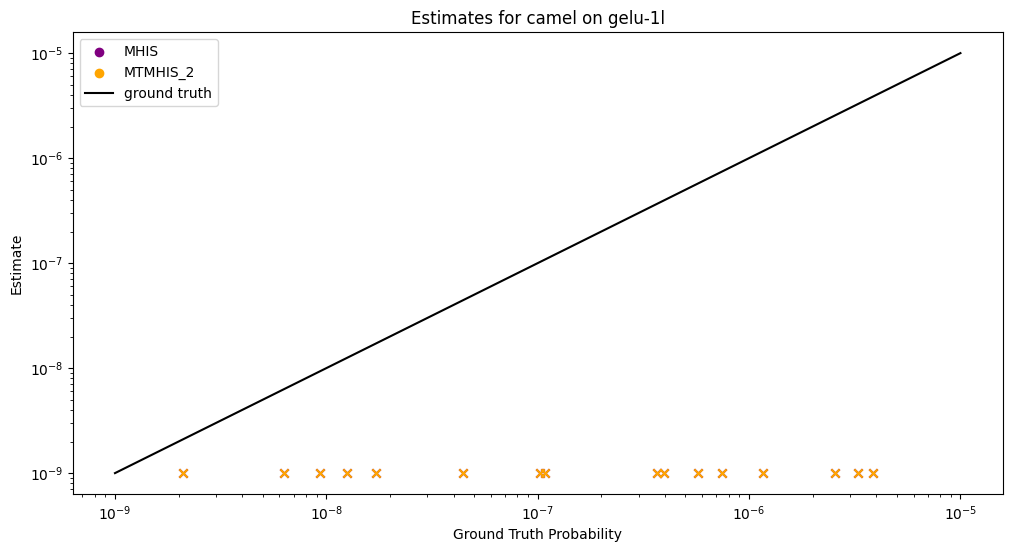

In [24]:
# Plot the (unfit) estimates
plt.figure(figsize=(12, 6))
colors = {'MTMHIS_2': 'orange', 'MHIS': 'purple'}
for method in methods:
    estimates_for_method = [estimates[method][target] for target in targets]
    print(method, len(estimates_for_method), estimates_for_method[:10])
    plt.scatter(gt_probs[targets].cpu().numpy(), estimates_for_method, label=method, color=colors[method])

    # Plot the 0s at the bottom
    zero_targets = list(filter(lambda target: estimates[method][target] == 0, targets))
    plt.scatter(gt_probs[zero_targets].cpu().numpy(), [1e-9]*len(zero_targets), color=colors[method], marker='x')


plt.plot([1e-9, 1e-5], [1e-9, 1e-5], label='ground truth', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ground Truth Probability')
plt.ylabel('Estimate')
plt.title(f"Estimates for {dist_name} on {model_name}")
plt.legend()
plt.show()